# Imports

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

# Hyperparameters and settings

In [2]:
EPOCHS = 100
BATCH_SIZE = 32

IMG_DIMENSIONS = (128, 128)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
print(DEVICE)

cuda:0


In [4]:
sns.set()

# Functions

In [5]:
labels = pd.read_csv("labels.csv")

In [6]:
labels.head()

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)


In [7]:
# Getting training data
training_data = dict()
class_names = dict()
training_data_path = "./traffic_Data/DATA"
for folder in os.listdir(training_data_path):
    subfolders_path = training_data_path + "/" + folder
    label, class_name = int(folder), labels[labels["ClassId"] == int(folder)].values[0][1] # It's 2 dimensional array 0 takes out data from matrix - 1 takes out name from array
    training_data[label], class_names[label] = [], class_name
    for image in os.listdir(subfolders_path):
        training_data[label].append(subfolders_path + "/" + image)

In [8]:
# Getting test data
test_data = {}
test_data_path = "./traffic_Data/TEST"
for image in os.listdir(test_data_path):
    image_class = int(image.split("_")[0])
    if image_class not in test_data.keys():
        test_data[image_class] = []
    test_data[image_class].append(test_data_path + "/" + image)

In [9]:
len(training_data.keys())

58

Text(0.5, 1.0, 'Distribution of classes in training part of the dataset.')

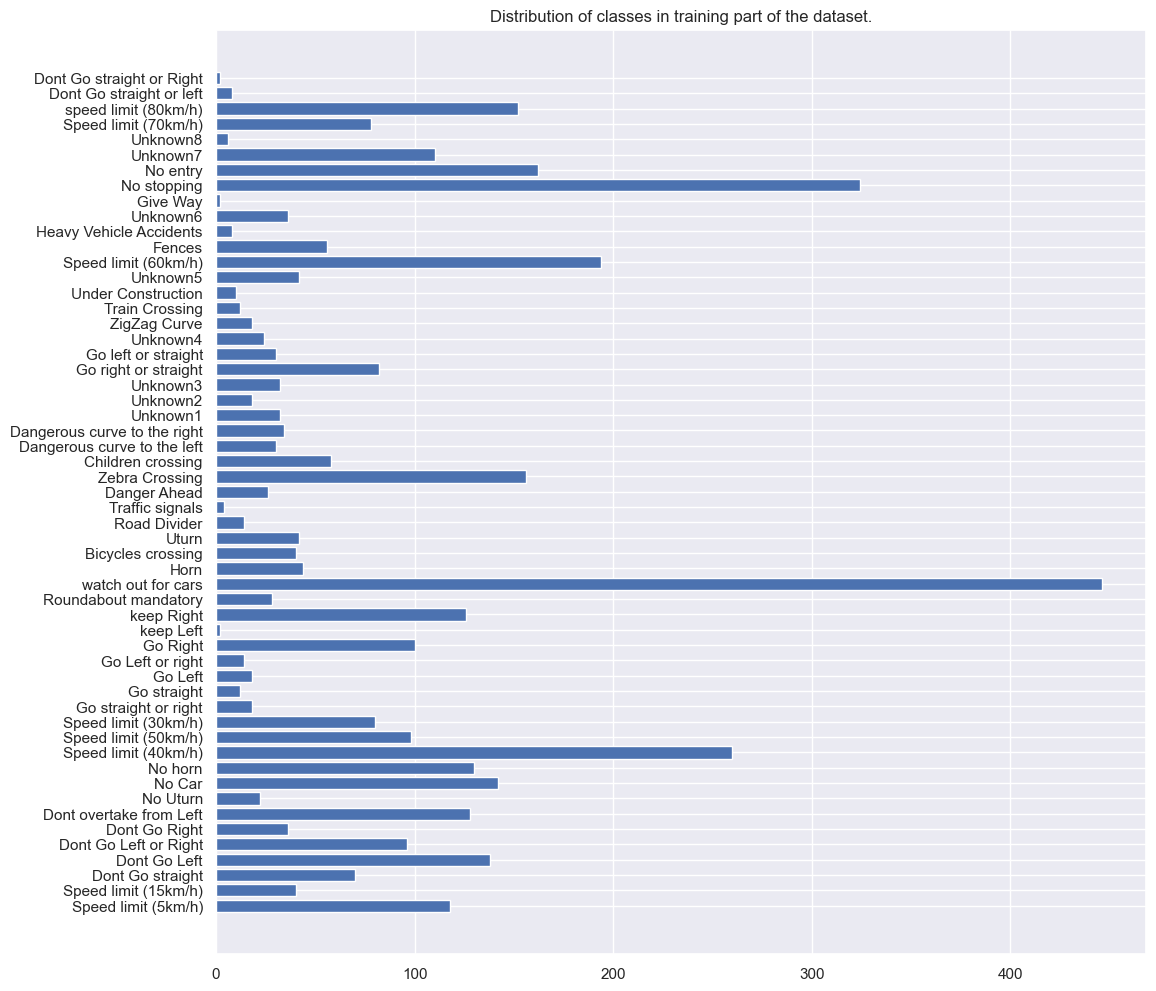

In [10]:
# Getting distribution of classes inside training part of the dataset
fig, ax = plt.subplots(figsize=(12, 12))

data = dict()

for label, files in training_data.items():
    name = class_names[int(label)]
    amount = len(files)
    data[name] = amount

ax.barh(list(data.keys()), list(data.values()))
plt.title("Distribution of classes in training part of the dataset.")

Text(0.5, 1.0, 'Distribution of classes in test part of the dataset.')

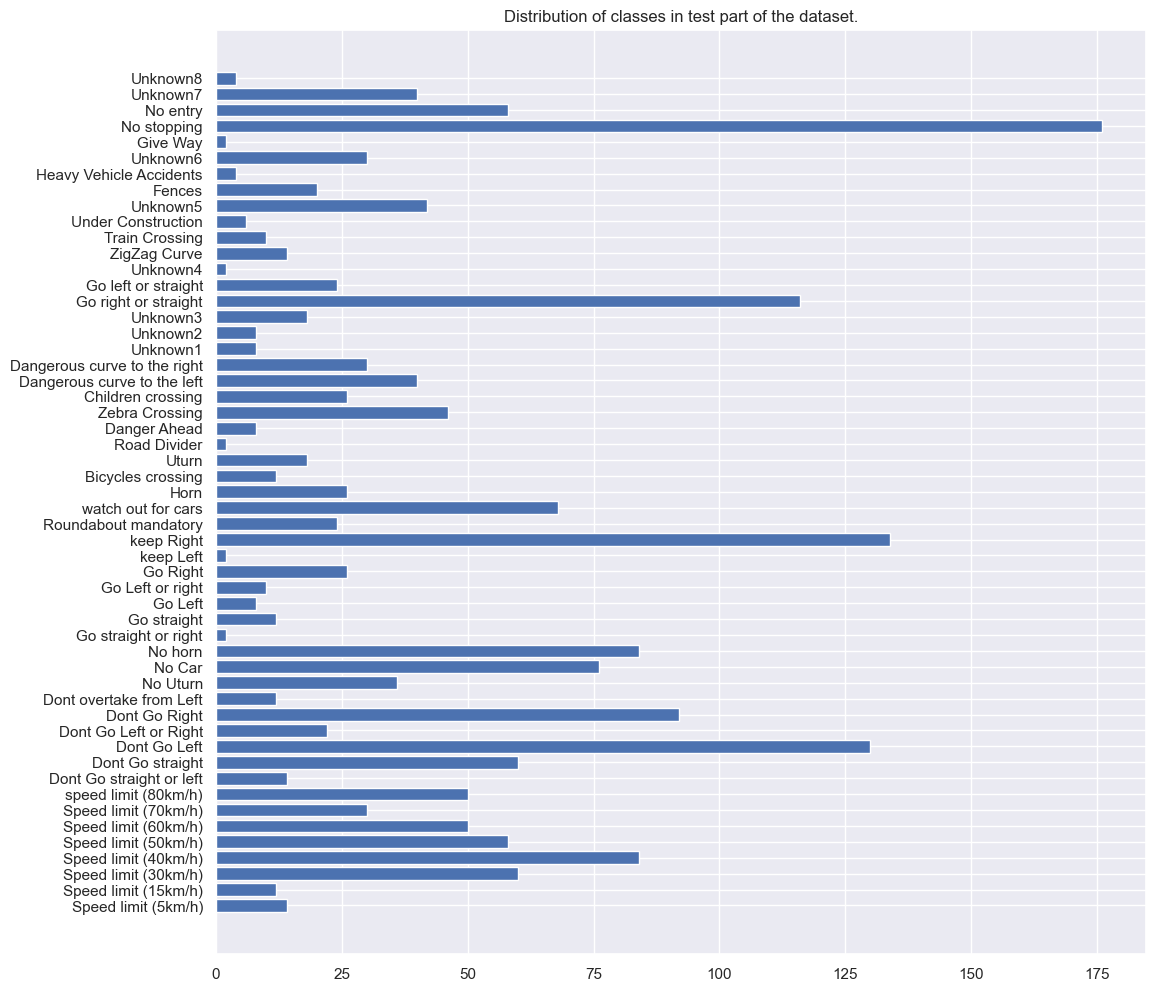

In [11]:
# Getting distribution of classes inside test part of the dataset
fig, ax = plt.subplots(figsize=(12, 12))

data = dict()

for label, files in test_data.items():
    name = class_names[int(label)]
    amount = len(files)
    data[name] = amount

ax.barh(list(data.keys()), list(data.values()))
plt.title("Distribution of classes in test part of the dataset.")

In [12]:
image_paths = list()
targets = list()
for label, _image_paths in training_data.items():
    for image_path in _image_paths:
        image_paths.append(image_path)
        targets.append(label)

In [13]:
class ImageIterator(Dataset):
    def __init__(self, images, targets):
        super().__init__()
        self.X = np.array(images)
        self.y = np.array(targets)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        image_path = self.X[index]
        image_class = self.y[index]
        
        image = Image.open(image_path)
        scaled_image = image.resize(IMG_DIMENSIONS)
        normalized_image_array = np.asarray(scaled_image) / 255
        
        target = [0] * 58
        target[image_class] = 1
        
        return torch.tensor(normalized_image_array, dtype=torch.float), torch.tensor(target, dtype=torch.float)

In [14]:
training_iterator = ImageIterator(image_paths, targets)
training_loader = DataLoader(training_iterator, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
x, y = next(iter(training_loader))

In [16]:
x = x.to(DEVICE)
y = y.to(DEVICE)

In [17]:
class PyramidClassificator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 2)
        self.relu1 = nn.ReLU()
        self.max_pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.flatten2 = nn.Flatten()
        self.relu2 = nn.ReLU()
        self.max_pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 32, 2)
        self.flatten3 = nn.Flatten()
        self.relu3 = nn.ReLU()
        
        self.out2_block = nn.Sequential(
            nn.Linear(30752, 32),
            nn.ReLU()
        )
        
        self.out3_block = nn.Sequential(
            nn.Linear(28800, 32),
            nn.ReLU()
        )
        
        self.final_layer = nn.Sequential(
            nn.Linear(64, 58),
        )
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        
        out1 = self.conv1(x)
        out1 = self.max_pool1(out1)
        out1 = self.relu1(out1)
        
        out2 = self.conv2(out1)
        out2 = self.max_pool2(out2)
        out2 = self.relu2(out2)
        out2_flatten = self.flatten2(out2)
        
        out3 = self.conv3(out2)
        out3 = self.relu3(out3)
        out3_flatten = self.flatten3(out3)
        
        preds2 = self.out2_block(out2_flatten)
        preds3 = self.out3_block(out3_flatten)
        
        preds = torch.cat([preds2, preds3], dim=1)
        
        return self.final_layer(preds)


In [18]:
model = PyramidClassificator()

In [19]:
model.to(DEVICE)

PyramidClassificator(
  (conv1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
  (relu1): ReLU()
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (flatten2): Flatten(start_dim=1, end_dim=-1)
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (flatten3): Flatten(start_dim=1, end_dim=-1)
  (relu3): ReLU()
  (out2_block): Sequential(
    (0): Linear(in_features=30752, out_features=32, bias=True)
    (1): ReLU()
  )
  (out3_block): Sequential(
    (0): Linear(in_features=28800, out_features=32, bias=True)
    (1): ReLU()
  )
  (final_layer): Sequential(
    (0): Linear(in_features=64, out_features=58, bias=True)
  )
)

In [20]:
res = model(x)
res.shape

torch.Size([32, 58])

In [21]:
y

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [22]:
optimizer = Adam(model.parameters(), lr = 0.001)

In [23]:
criterion = nn.CrossEntropyLoss()

In [24]:
optimizer.param_groups[0]['lr']

0.001

In [25]:
losses = []

In [26]:
model.train()

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}")
    for inp, label in tqdm(training_loader):
        optimizer.zero_grad()
        
        out = model(inp.to(DEVICE))
        label = label.to(DEVICE)
        loss = criterion(out, label)
        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.item())
    
    print(f"Loss: {np.mean(losses)}")

Epoch: 1


100%|██████████| 131/131 [00:07<00:00, 17.24it/s]


Loss: 2.73912876525908
Epoch: 2


100%|██████████| 131/131 [00:08<00:00, 15.29it/s]


Loss: 1.8575157532255158
Epoch: 3


100%|██████████| 131/131 [00:08<00:00, 14.85it/s]


Loss: 1.3883265920419425
Epoch: 4


100%|██████████| 131/131 [00:07<00:00, 16.41it/s]


Loss: 1.1050766244253414
Epoch: 5


100%|██████████| 131/131 [00:07<00:00, 16.99it/s]


Loss: 0.9096041945612613
Epoch: 6


100%|██████████| 131/131 [00:08<00:00, 15.50it/s]


Loss: 0.7722320440509677
Epoch: 7


100%|██████████| 131/131 [00:08<00:00, 15.28it/s]


Loss: 0.6734117495684174
Epoch: 8


100%|██████████| 131/131 [00:07<00:00, 17.17it/s]


Loss: 0.5918148731753294
Epoch: 9


100%|██████████| 131/131 [00:08<00:00, 15.56it/s]


Loss: 0.5278653281757532
Epoch: 10


100%|██████████| 131/131 [00:08<00:00, 14.56it/s]


Loss: 0.47571369769555544
Epoch: 11


100%|██████████| 131/131 [00:08<00:00, 14.80it/s]


Loss: 0.4327147996150772
Epoch: 12


100%|██████████| 131/131 [00:08<00:00, 14.71it/s]


Loss: 0.39777068749495836
Epoch: 13


100%|██████████| 131/131 [00:08<00:00, 14.70it/s]


Loss: 0.36865037192785494
Epoch: 14


100%|██████████| 131/131 [00:08<00:00, 15.15it/s]


Loss: 0.34719906366630043
Epoch: 15


100%|██████████| 131/131 [00:07<00:00, 16.94it/s]


Loss: 0.3252209520082371
Epoch: 16


100%|██████████| 131/131 [00:08<00:00, 15.63it/s]


Loss: 0.30617908976036173
Epoch: 17


100%|██████████| 131/131 [00:08<00:00, 16.10it/s]


Loss: 0.2891936506736371
Epoch: 18


100%|██████████| 131/131 [00:08<00:00, 14.82it/s]


Loss: 0.27321837354116396
Epoch: 19


100%|██████████| 131/131 [00:08<00:00, 15.59it/s]


Loss: 0.2588622032886763
Epoch: 20


100%|██████████| 131/131 [00:08<00:00, 15.41it/s]


Loss: 0.2459356698549791
Epoch: 21


100%|██████████| 131/131 [00:07<00:00, 16.43it/s]


Loss: 0.23423703573944415
Epoch: 22


100%|██████████| 131/131 [00:07<00:00, 16.42it/s]


Loss: 0.2235998746767568
Epoch: 23


100%|██████████| 131/131 [00:08<00:00, 15.87it/s]


Loss: 0.21388631318108486
Epoch: 24


100%|██████████| 131/131 [00:08<00:00, 14.99it/s]


Loss: 0.2049811995947415
Epoch: 25


100%|██████████| 131/131 [00:08<00:00, 15.36it/s]


Loss: 0.1967876480308087
Epoch: 26


100%|██████████| 131/131 [00:08<00:00, 15.02it/s]


Loss: 0.18922372115883943
Epoch: 27


100%|██████████| 131/131 [00:07<00:00, 16.69it/s]


Loss: 0.1822197241989344
Epoch: 28


100%|██████████| 131/131 [00:08<00:00, 14.87it/s]


Loss: 0.17571553665029824
Epoch: 29


100%|██████████| 131/131 [00:07<00:00, 16.67it/s]


Loss: 0.16965954147948276
Epoch: 30


100%|██████████| 131/131 [00:08<00:00, 15.06it/s]


Loss: 0.16400703519396664
Epoch: 31


100%|██████████| 131/131 [00:07<00:00, 16.67it/s]


Loss: 0.15871895293518554
Epoch: 32


100%|██████████| 131/131 [00:08<00:00, 15.13it/s]


Loss: 0.15376115698390413
Epoch: 33


100%|██████████| 131/131 [00:08<00:00, 15.56it/s]


Loss: 0.14910365711995788
Epoch: 34


100%|██████████| 131/131 [00:07<00:00, 16.53it/s]


Loss: 0.14471997560640207
Epoch: 35


100%|██████████| 131/131 [00:08<00:00, 15.12it/s]


Loss: 0.1405866415727091
Epoch: 36


100%|██████████| 131/131 [00:08<00:00, 15.00it/s]


Loss: 0.13668281233515067
Epoch: 37


100%|██████████| 131/131 [00:08<00:00, 16.03it/s]


Loss: 0.13298988069054038
Epoch: 38


100%|██████████| 131/131 [00:08<00:00, 14.96it/s]


Loss: 0.12949124787979213
Epoch: 39


100%|██████████| 131/131 [00:08<00:00, 14.75it/s]


Loss: 0.1261719172740997
Epoch: 40


100%|██████████| 131/131 [00:08<00:00, 14.71it/s]


Loss: 0.12301848225824454
Epoch: 41


100%|██████████| 131/131 [00:09<00:00, 14.51it/s]


Loss: 0.12001880273371283
Epoch: 42


100%|██████████| 131/131 [00:08<00:00, 15.70it/s]


Loss: 0.11716191538129281
Epoch: 43


100%|██████████| 131/131 [00:08<00:00, 15.40it/s]


Loss: 0.11443783701058521
Epoch: 44


100%|██████████| 131/131 [00:08<00:00, 14.80it/s]


Loss: 0.11183756159466093
Epoch: 45


100%|██████████| 131/131 [00:08<00:00, 14.91it/s]


Loss: 0.10935280012302666
Epoch: 46


100%|██████████| 131/131 [00:08<00:00, 14.57it/s]


Loss: 0.10697603762362601
Epoch: 47


100%|██████████| 131/131 [00:08<00:00, 14.56it/s]


Loss: 0.10470038670131837
Epoch: 48


100%|██████████| 131/131 [00:09<00:00, 14.46it/s]


Loss: 0.10251951286606582
Epoch: 49


100%|██████████| 131/131 [00:08<00:00, 15.04it/s]


Loss: 0.1004276178920382
Epoch: 50


100%|██████████| 131/131 [00:08<00:00, 14.71it/s]


Loss: 0.09841939009421391
Epoch: 51


100%|██████████| 131/131 [00:09<00:00, 14.55it/s]


Loss: 0.09648988250845379
Epoch: 52


100%|██████████| 131/131 [00:08<00:00, 14.64it/s]


Loss: 0.09463456832822419
Epoch: 53


100%|██████████| 131/131 [00:08<00:00, 14.60it/s]


Loss: 0.09284924940115688
Epoch: 54


100%|██████████| 131/131 [00:09<00:00, 14.32it/s]


Loss: 0.0911300345256252
Epoch: 55


100%|██████████| 131/131 [00:07<00:00, 17.66it/s]


Loss: 0.0894733196270608
Epoch: 56


100%|██████████| 131/131 [00:07<00:00, 17.21it/s]


Loss: 0.08787576377415988
Epoch: 57


100%|██████████| 131/131 [00:08<00:00, 14.92it/s]


Loss: 0.08633425191251284
Epoch: 58


100%|██████████| 131/131 [00:08<00:00, 15.33it/s]


Loss: 0.0848458849274395
Epoch: 59


 65%|██████▍   | 85/131 [00:06<00:03, 14.00it/s]


KeyboardInterrupt: 

In [27]:
test_image_paths = []
test_targets = []

for label, _image_paths in test_data.items():
    for image_path in _image_paths:
        test_image_paths.append(image_path)
        test_targets.append(label)

test_iterator = ImageIterator(test_image_paths, test_targets)
test_loader = DataLoader(test_iterator, batch_size=BATCH_SIZE, shuffle=False)

model.eval()

total_predictions = 0
correct_predictions = 0

for inputs, labels in test_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(inputs)
    
    _, predicted = torch.max(outputs, 1)
    
    total_predictions += labels.size(0)
    
    correct_predictions += (predicted == torch.argmax(labels, dim=1)).sum().item()

accuracy = correct_predictions / total_predictions
print(f"Accuracy on test data: {accuracy:.2f}")


Accuracy on test data: 0.52
